#EDA and Data Setup

In [24]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
from keras.utils import FeatureSpace
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix



# additional libraries to make confusion matrix (also uses "matplotlib.pyplot")
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
path = "/clinical_glioma_grading.csv"
# Replace 'your_file.csv' with the actual path to your CSV file
glioma = pd.read_csv(path)

# Display the first few rows of the DataFrame
glioma.head()
#print(glioma.info())
#print(glioma.describe())



,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,0,0,51.30,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,38.72,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,35.17,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,32.78,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,31.51,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


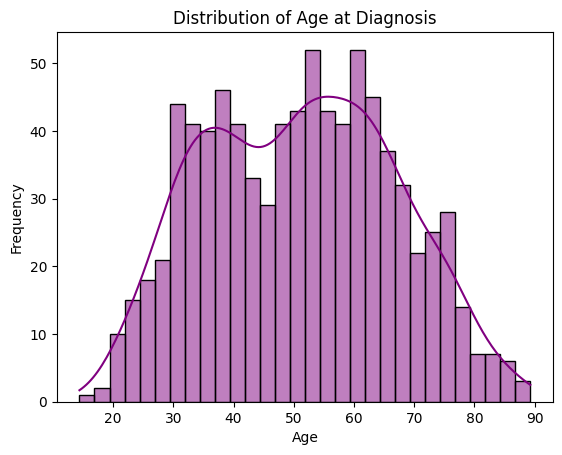

<Axes: xlabel='Grade', ylabel='count'>

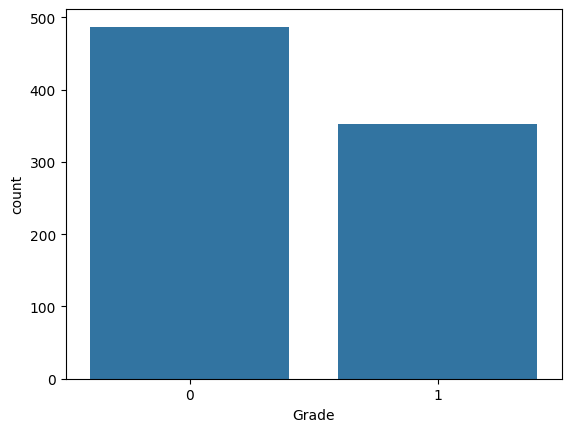

In [6]:
sns.histplot(data=glioma, x='Age_at_diagnosis', kde=True, bins=30, color='purple')
plt.title('Distribution of Age at Diagnosis')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

sns.countplot(data=glioma, x='Grade')



<Axes: xlabel='Grade', ylabel='Age_at_diagnosis'>

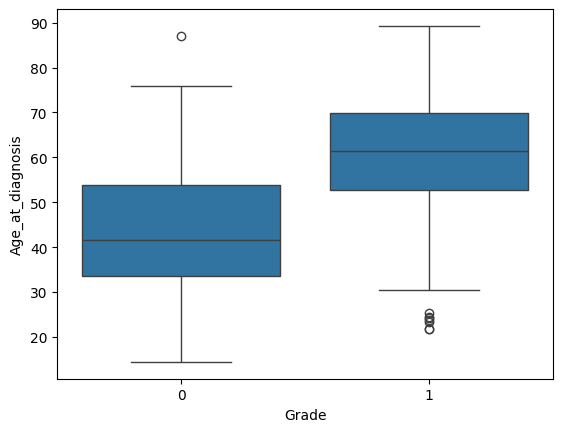

In [7]:
sns.boxplot(data=glioma, x='Grade', y='Age_at_diagnosis')


In [8]:
frame1 = glioma.sample(frac=0.5, random_state=1)
frame2 = glioma.drop(frame1.index)
print("frame1 shape: ", frame1.shape)
print("frame2 shape: ", frame2.shape)

frame1 shape:  (420, 24)
frame2 shape:  (419, 24)


In [27]:
# Split into features and target
target_col = 'Grade'
X = glioma.drop(columns=[target_col])
y = glioma[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine for  compatibility
train_df = X_train.copy()
train_df[target_col] = y_train
test_df = X_test.copy()
test_df[target_col] = y_test


Categorical Variables are one-hot encoded, and then combined with numerical columns.

In [28]:
categorical_cols = ['Gender', 'Race']  # Binary encoded features
numerical_cols = ['Age_at_diagnosis'] + [col for col in X.columns if col not in categorical_cols+['Age_at_diagnosis']]

# Define FeatureSpace with proper dictionary syntax
fs = FeatureSpace(
    features={
        **{col: FeatureSpace.float_normalized() for col in numerical_cols},
        **{col: FeatureSpace.integer_categorical(num_oov_indices=0, output_mode="one_hot")
           for col in categorical_cols}
    },
    output_mode="concat"
)
# Convert dataframe to tf.data.Dataset (features only)
train_features = train_df.drop(columns=[target_col])
train_ds = tf.data.Dataset.from_tensor_slices(dict(train_features)).batch(32)

# Adapt featurespace
fs.adapt(train_ds)  # No more ValueError


In [29]:
# Transform DataFrames into dictionary
def dataframe_to_feature_dict(df):
    return {col: tf.convert_to_tensor(df[col]) for col in df.columns if col != target_col}

X_train_fs = fs(dataframe_to_feature_dict(train_df))
X_test_fs = fs(dataframe_to_feature_dict(test_df))
y_train_fs = y_train.to_numpy().astype("float32")



#Base model from Sample Code

In [30]:
# Build and train the model
model = keras.Sequential([
    keras.Input(shape=(X_train_fs.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_fs, y_train_fs,
    validation_split=0.5,
    epochs=20,
    batch_size=32
)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5589 - loss: 0.7601 - val_accuracy: 0.5357 - val_loss: 0.7054
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5869 - loss: 0.6711 - val_accuracy: 0.5506 - val_loss: 0.6564
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6160 - loss: 0.6156 - val_accuracy: 0.6220 - val_loss: 0.6225
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7026 - loss: 0.5712 - val_accuracy: 0.6488 - val_loss: 0.5919
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7410 - loss: 0.5429 - val_accuracy: 0.6756 - val_loss: 0.5601
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7974 - loss: 0.4910 - val_accuracy: 0.7262 - val_loss: 0.5305
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8243 - loss: 0.4585 - val_accuracy: 0.7887 - val_loss: 0.4997
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8719 - loss: 0.4040 - val_accuracy: 0.8065 - v

#Performance Metrics of Base Model without 2 Fold CV


In [13]:
# Ensure y_test_fs is a NumPy array and convert to integer type
y_test_fs = y_test.astype("int")

# Predict and evaluate
y_pred = (model.predict(X_test_fs) > 0.5).astype(int).flatten()

# Evaluation report
print(classification_report(y_test_fs, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test_fs, y_pred)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        98
           1       0.80      0.84      0.82        70

    accuracy                           0.85       168
   macro avg       0.84      0.84      0.84       168
weighted avg       0.85      0.85      0.85       168



In [31]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

# Combine training and test data
X_fs = np.concatenate([X_train_fs, X_test_fs], axis=0)
y_fs = np.concatenate([y_train, y_test], axis=0)

# Ensure data is in NumPy format
X_fs = X_fs.astype("float32")
y_fs = y_fs.astype("int")

# Define 2-fold cross-validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)

#Performance vs Number of Epochs


--- Fold 1 ---

--- Fold 2 ---


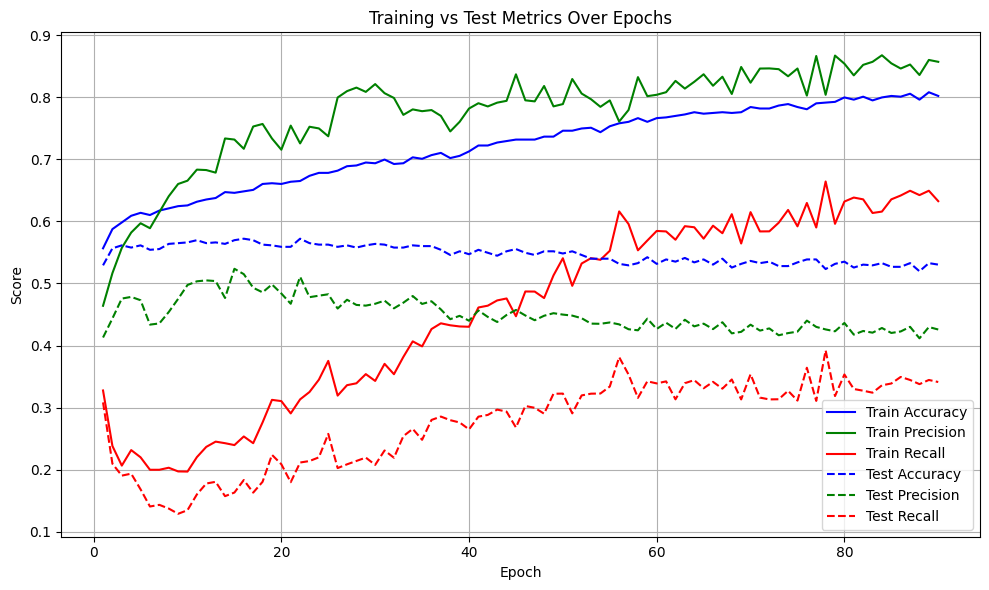

In [20]:
# Combine training and test data
X_fs = np.concatenate([X_train_fs, X_test_fs], axis=0)
y_fs = np.concatenate([y_train, y_test], axis=0)

# Ensure data is in NumPy format
X_fs = X_fs.astype("float32")
y_fs = y_fs.astype("int")

# Define 2-fold cross-validation

epochs = 90
metrics = {
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "test_accuracy": [],
    "test_precision": [],
    "test_recall": []
}

# Epoch-wise metrics averaged across folds
epoch_metrics = {k: np.zeros(epochs) for k in metrics.keys()}

for fold, (train_index, test_index) in enumerate(kf.split(X_fs), 1):
    print(f"\n--- Fold {fold} ---")

    X_train, X_test = X_fs[train_index], X_fs[test_index]
    y_train, y_test = y_fs[train_index], y_fs[test_index]

    # Build a fresh model
    model = keras.Sequential([
        keras.Input(shape=(X_train.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    for epoch in range(epochs):
        # Train for one epoch
        model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)

        # Predict on training and test sets
        y_train_pred = (model.predict(X_train, verbose=0) > 0.5).astype(int).flatten()
        y_test_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()

        # Collect metrics
        epoch_metrics["train_accuracy"][epoch] += accuracy_score(y_train, y_train_pred)
        epoch_metrics["train_precision"][epoch] += precision_score(y_train, y_train_pred, zero_division=0)
        epoch_metrics["train_recall"][epoch] += recall_score(y_train, y_train_pred, zero_division=0)

        epoch_metrics["test_accuracy"][epoch] += accuracy_score(y_test, y_test_pred)
        epoch_metrics["test_precision"][epoch] += precision_score(y_test, y_test_pred, zero_division=0)
        epoch_metrics["test_recall"][epoch] += recall_score(y_test, y_test_pred, zero_division=0)

# Average metrics across folds
for k in epoch_metrics:
    epoch_metrics[k] /= 2

# Plotting
# Colors and line styles for each metric
colors = {
    "train_accuracy": "blue",
    "test_accuracy": "blue",
    "train_precision": "green",
    "test_precision": "green",
    "train_recall": "red",
    "test_recall": "red"
}
linestyles = {
    "train_accuracy": "-",
    "test_accuracy": "--",
    "train_precision": "-",
    "test_precision": "--",
    "train_recall": "-",
    "test_recall": "--"
}

plt.figure(figsize=(10, 6))
for key, values in epoch_metrics.items():
    label = key.replace("_", " ").title()
    plt.plot(range(1, epochs + 1), values, label=label,
             color=colors[key], linestyle=linestyles[key])

plt.title("Training vs Test Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Performance vs Number of Hidden Layers


=== Evaluating 1 hidden layer(s) ===

=== Evaluating 2 hidden layer(s) ===

=== Evaluating 3 hidden layer(s) ===

=== Evaluating 4 hidden layer(s) ===

=== Evaluating 5 hidden layer(s) ===

=== Evaluating 6 hidden layer(s) ===

=== Evaluating 7 hidden layer(s) ===


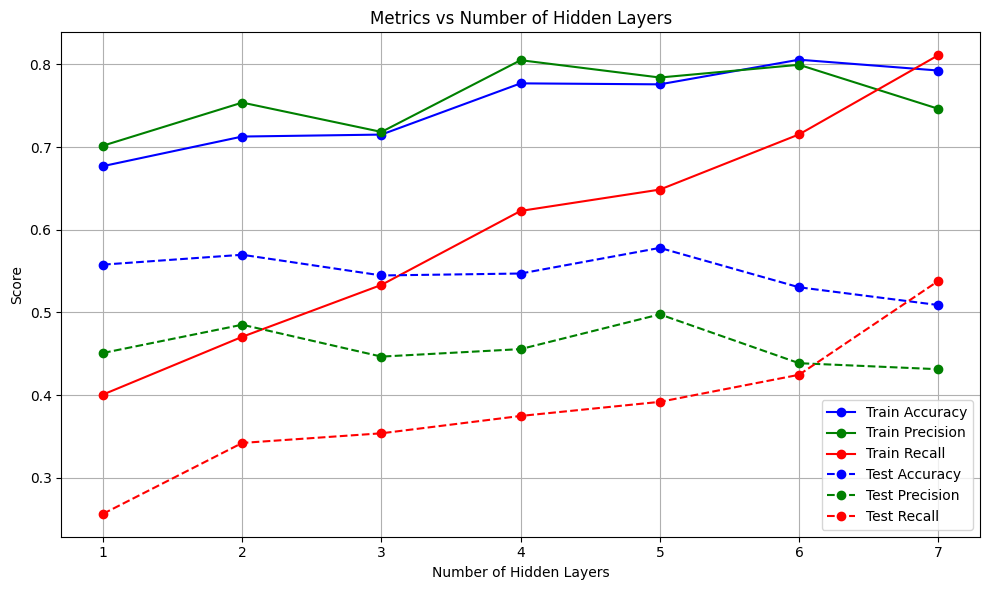

In [18]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Combine and prepare data
X_fs = np.concatenate([X_train_fs, X_test_fs], axis=0).astype("float32")
y_fs = np.concatenate([y_train, y_test], axis=0).astype("int")

kf = KFold(n_splits=2, shuffle=True, random_state=42)
epochs = 20
layer_counts = [1, 2, 3, 4, 5, 6, 7]  # Number of hidden layers to test

# Store metrics
results = {
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "test_accuracy": [],
    "test_precision": [],
    "test_recall": []
}

for num_layers in layer_counts:
    print(f"\n=== Evaluating {num_layers} hidden layer(s) ===")
    fold_metrics = {k: [] for k in results.keys()}

    for fold, (train_index, test_index) in enumerate(kf.split(X_fs), 1):
        X_train, X_test = X_fs[train_index], X_fs[test_index]
        y_train, y_test = y_fs[train_index], y_fs[test_index]

        # Build model with `num_layers` hidden layers
        model = keras.Sequential()
        model.add(keras.Input(shape=(X_train.shape[1],)))
        for _ in range(num_layers):
            model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

        # Predictions
        y_train_pred = (model.predict(X_train, verbose=0) > 0.5).astype(int).flatten()
        y_test_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()

        # Metrics
        fold_metrics["train_accuracy"].append(accuracy_score(y_train, y_train_pred))
        fold_metrics["train_precision"].append(precision_score(y_train, y_train_pred, zero_division=0))
        fold_metrics["train_recall"].append(recall_score(y_train, y_train_pred, zero_division=0))

        fold_metrics["test_accuracy"].append(accuracy_score(y_test, y_test_pred))
        fold_metrics["test_precision"].append(precision_score(y_test, y_test_pred, zero_division=0))
        fold_metrics["test_recall"].append(recall_score(y_test, y_test_pred, zero_division=0))

    # Average metrics over folds
    for key in results:
        results[key].append(np.mean(fold_metrics[key]))

# --- Plotting ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
colors = {
    "train_accuracy": "blue",
    "test_accuracy": "blue",
    "train_precision": "green",
    "test_precision": "green",
    "train_recall": "red",
    "test_recall": "red"
}
linestyles = {
    "train_accuracy": "-",
    "test_accuracy": "--",
    "train_precision": "-",
    "test_precision": "--",
    "train_recall": "-",
    "test_recall": "--"
}

for key, values in results.items():
    label = key.replace("_", " ").title()
    plt.plot(layer_counts, values, label=label,
             color=colors[key], linestyle=linestyles[key], marker='o')

plt.title("Metrics vs Number of Hidden Layers")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Performance vs Units per Layer


=== Evaluating 8 hidden units per layer ===

=== Evaluating 16 hidden units per layer ===

=== Evaluating 32 hidden units per layer ===

=== Evaluating 64 hidden units per layer ===

=== Evaluating 128 hidden units per layer ===


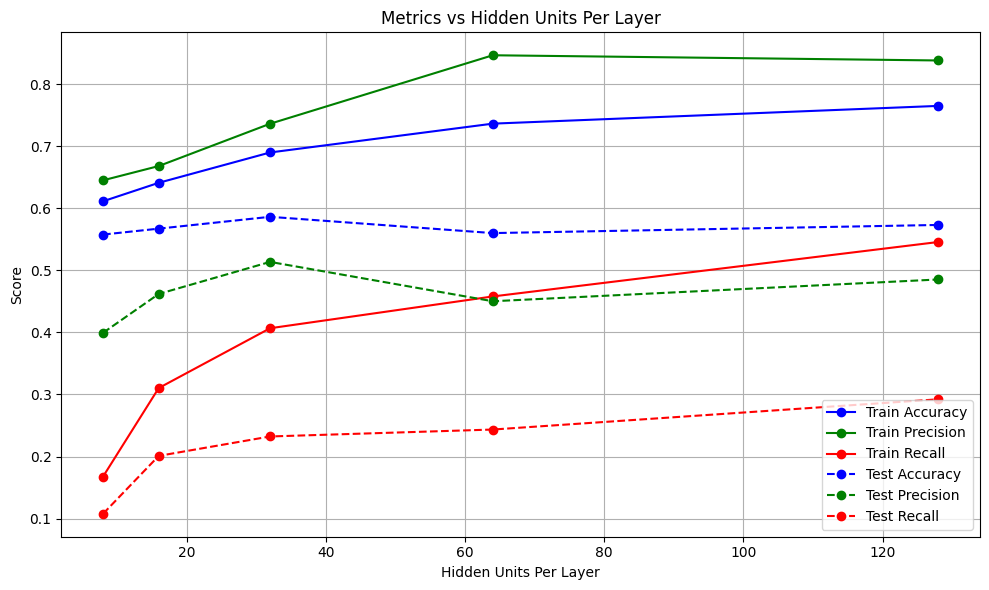

In [19]:
# Combine and prepare data
X_fs = np.concatenate([X_train_fs, X_test_fs], axis=0).astype("float32")
y_fs = np.concatenate([y_train, y_test], axis=0).astype("int")

kf = KFold(n_splits=2, shuffle=True, random_state=42)
epochs = 20
hidden_units_list = [8, 16, 32, 64, 128]  # Units per layer
num_hidden_layers = 2  # Fixed number of layers

# Store metrics
results = {
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "test_accuracy": [],
    "test_precision": [],
    "test_recall": []
}

for units in hidden_units_list:
    print(f"\n=== Evaluating {units} hidden units per layer ===")
    fold_metrics = {k: [] for k in results.keys()}

    for fold, (train_index, test_index) in enumerate(kf.split(X_fs), 1):
        X_train, X_test = X_fs[train_index], X_fs[test_index]
        y_train, y_test = y_fs[train_index], y_fs[test_index]

        # Build model with `num_hidden_layers` and `units` per layer
        model = keras.Sequential()
        model.add(keras.Input(shape=(X_train.shape[1],)))
        for _ in range(num_hidden_layers):
            model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

        # Predictions
        y_train_pred = (model.predict(X_train, verbose=0) > 0.5).astype(int).flatten()
        y_test_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()

        # Metrics
        fold_metrics["train_accuracy"].append(accuracy_score(y_train, y_train_pred))
        fold_metrics["train_precision"].append(precision_score(y_train, y_train_pred, zero_division=0))
        fold_metrics["train_recall"].append(recall_score(y_train, y_train_pred, zero_division=0))

        fold_metrics["test_accuracy"].append(accuracy_score(y_test, y_test_pred))
        fold_metrics["test_precision"].append(precision_score(y_test, y_test_pred, zero_division=0))
        fold_metrics["test_recall"].append(recall_score(y_test, y_test_pred, zero_division=0))

    # Average metrics over folds
    for key in results:
        results[key].append(np.mean(fold_metrics[key]))

# --- Plotting ---
plt.figure(figsize=(10, 6))
colors = {
    "train_accuracy": "blue",
    "test_accuracy": "blue",
    "train_precision": "green",
    "test_precision": "green",
    "train_recall": "red",
    "test_recall": "red"
}
linestyles = {
    "train_accuracy": "-",
    "test_accuracy": "--",
    "train_precision": "-",
    "test_precision": "--",
    "train_recall": "-",
    "test_recall": "--"
}

for key, values in results.items():
    label = key.replace("_", " ").title()
    plt.plot(hidden_units_list, values, label=label,
             color=colors[key], linestyle=linestyles[key], marker='o')

plt.title("Metrics vs Hidden Units Per Layer")
plt.xlabel("Hidden Units Per Layer")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Metrics for Base Model


--- Fold 1 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       242
           1       0.82      0.85      0.84       178

    accuracy                           0.86       420
   macro avg       0.86      0.86      0.86       420
weighted avg       0.86      0.86      0.86       420


--- Fold 2 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       245
           1       0.79      0.84      0.81       174

    accuracy                           0.84       419
   macro avg       0.83      0.84      0.84       419
weighted avg       0.84      0.84      0.84       419



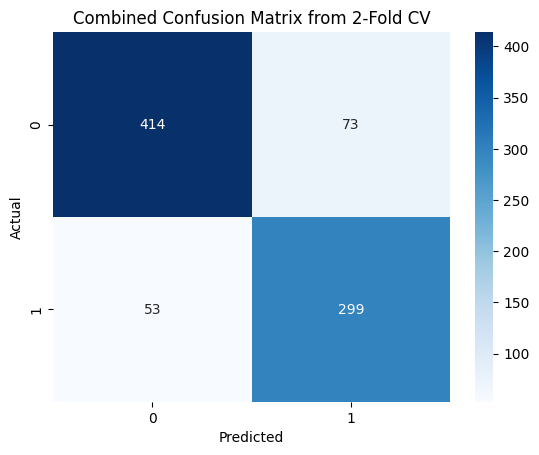


=== Average Metrics Across Folds ===
   Metric  Average (across folds)
Precision                0.803859
   Recall                0.849380
 F1-Score                0.825935
 Accuracy                0.849810


In [32]:


all_y_true = []
all_y_pred = []

# For averaging metrics
precision_list = []
recall_list = []
f1_list = []
accuracy_list = []

fold = 1
for train_index, test_index in kf.split(X_fs):
    print(f"\n--- Fold {fold} ---")

    X_train, X_test = X_fs[train_index], X_fs[test_index]
    y_train, y_test = y_fs[train_index], y_fs[test_index]

    model = keras.Sequential([
        keras.Input(shape=(X_train.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

    # Classification metrics for this fold
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = (y_pred == y_test).mean()

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    accuracy_list.append(accuracy)

    print(classification_report(y_test, y_pred))

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    fold += 1

# 📊 Combined Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Combined Confusion Matrix from 2-Fold CV')
plt.show()

# 📋 Average metrics table
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_accuracy = np.mean(accuracy_list)

summary_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Average (across folds)': [avg_precision, avg_recall, avg_f1, avg_accuracy]
})

print("\n=== Average Metrics Across Folds ===")
print(summary_df.to_string(index=False))


#Metrics for Adjusted Models


--- Fold 1 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       242
           1       0.81      0.88      0.84       178

    accuracy                           0.86       420
   macro avg       0.86      0.86      0.86       420
weighted avg       0.86      0.86      0.86       420


--- Fold 2 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       245
           1       0.76      0.93      0.83       174

    accuracy                           0.85       419
   macro avg       0.85      0.86      0.85       419
weighted avg       0.86      0.85      0.85       419



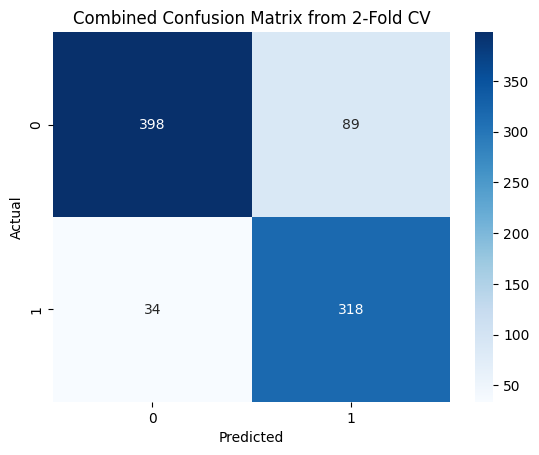


=== Average Metrics Across Folds ===
   Metric  Average (across folds)
Precision                0.782281
   Recall                0.903655
 F1-Score                0.838010
 Accuracy                0.853390


In [33]:
all_y_true = []
all_y_pred = []

# For averaging metrics
precision_list = []
recall_list = []
f1_list = []
accuracy_list = []

fold = 1
for train_index, test_index in kf.split(X_fs):
    print(f"\n--- Fold {fold} ---")

    X_train, X_test = X_fs[train_index], X_fs[test_index]
    y_train, y_test = y_fs[train_index], y_fs[test_index]

    model = keras.Sequential([
        keras.Input(shape=(X_train.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

    # Classification metrics for this fold
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = (y_pred == y_test).mean()

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    accuracy_list.append(accuracy)

    print(classification_report(y_test, y_pred))

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    fold += 1

# 📊 Combined Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Combined Confusion Matrix from 2-Fold CV')
plt.show()

# 📋 Average metrics table
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_accuracy = np.mean(accuracy_list)

summary_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Average (across folds)': [avg_precision, avg_recall, avg_f1, avg_accuracy]
})

print("\n=== Average Metrics Across Folds ===")
print(summary_df.to_string(index=False))


#Higher Epoch Training


--- Fold 1 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       242
           1       0.81      0.74      0.78       178

    accuracy                           0.82       420
   macro avg       0.82      0.81      0.81       420
weighted avg       0.82      0.82      0.82       420


--- Fold 2 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       245
           1       0.76      0.87      0.82       174

    accuracy                           0.84       419
   macro avg       0.83      0.84      0.83       419
weighted avg       0.84      0.84      0.84       419



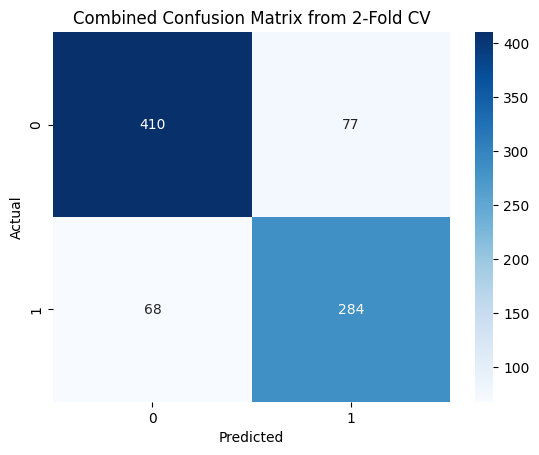


=== Average Metrics Across Folds ===
   Metric  Average (across folds)
Precision                0.789317
   Recall                0.807568
 F1-Score                0.795742
 Accuracy                0.827185


In [35]:
all_y_true = []
all_y_pred = []

# For averaging metrics
precision_list = []
recall_list = []
f1_list = []
accuracy_list = []

fold = 1
for train_index, test_index in kf.split(X_fs):
    print(f"\n--- Fold {fold} ---")

    X_train, X_test = X_fs[train_index], X_fs[test_index]
    y_train, y_test = y_fs[train_index], y_fs[test_index]

    model2 = keras.Sequential([
        keras.Input(shape=(X_train.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model2.fit(X_train, y_train, epochs=600, batch_size=32, verbose=0)

    y_pred = (model2.predict(X_test) > 0.5).astype(int).flatten()

    # Classification metrics for this fold
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = (y_pred == y_test).mean()

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    accuracy_list.append(accuracy)

    print(classification_report(y_test, y_pred))

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    fold += 1

# 📊 Combined Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Combined Confusion Matrix from 2-Fold CV')
plt.show()

# 📋 Average metrics table
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_accuracy = np.mean(accuracy_list)

summary_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Average (across folds)': [avg_precision, avg_recall, avg_f1, avg_accuracy]
})

print("\n=== Average Metrics Across Folds ===")
print(summary_df.to_string(index=False))
